# Preliminary Learning Investigation

Here we explore some off-the-shelf learning strategies for identifying datasets to be flagged based on the results of the AutoQC suite of tests.

 - **AutoQC Version:** `learning-0.0.1`
 - **Dataset:** full quota dataset (unreleased)
 - **OS:** osx 10.10.3
 - **python:** Python 2.7.10 :: Anaconda 2.3.0 (x86_64); see `pip_freeze.dat` for package versions.
 
## 0.1: Data Reduction

The full dataset was processed by AutoQC, and the results logged as JSON serializations.


In [73]:
import json

def reloadData(): 
    ## read raw data
    with open('../../../AutoQC_raw/true.dat') as true_data:    
        truth = json.load(true_data)

    with open('../../../AutoQC_raw/results.dat') as results_data:    
        rawResults = json.load(results_data)
        
    return truth, rawResults

truth, rawResults = reloadData()
datasetSize = len(truth)

## 0.2: Helpers

A few helpers and parameters are defined here for subsequent use. 

In [76]:
import random
import numpy as np

def shuffleLists(a, b):
  '''
  given two lists a, b, shuffle them maintaining pairwise correspondence.
  thanks http://stackoverflow.com/questions/13343347/randomizing-two-lists-and-maintaining-order-in-python
  '''

  combined = zip(a, b)
  random.seed(2154)
  random.shuffle(combined)

  a[:], b[:] = zip(*combined)

def transpose(lists):
    '''
    return the transpose of lists, a list of lists.
    all the inner lists had better be the same length!
    '''

    T = []
    for i in range(len(lists[0])):
        T.append([None]*len(lists))

    for i in range(len(lists)):
        for j in range(len(lists[0])):
            T[j][i] = lists[i][j]

    return T

def runClassifier(classifier, trainingSize):
    '''
    given a scikit-learn classifier, train it on the first trainingSize points of data and truth,
    and return the prediction classes on the remainder of data
    '''
    #load and arrange data
    truth, rawResults = reloadData()
    data = transpose(rawResults) #arrange data into rows by profile for consumption by scikit-learn
    shuffleLists(data, truth)    #randomize order of profiles
    
    #train svm
    classifier.fit(data[0:trainingSize], truth[0:trainingSize])

    #predict values for remainder of profiles
    TT = 0.
    TF = 0.
    FT = 0.
    FF = 0.

    for i in range(trainingSize, len(truth)):
        assessment = classifier.predict(data[i])
        if assessment and truth[i]:
            TT += 1
        elif assessment and not truth[i]:
            TF += 1
        elif not assessment and truth[i]:
            FT += 1
        elif not assessment and not truth[i]:
            FF += 1  
            
    return TT, TF, FT, FF

trainingSize = 5000

## 0.3: Perfomance to Beat

To start, we consider the performance of each of the 13 tests implemented in `learning-0.0.1` independently; that is, how would they perform in the absense of all other information?

In [75]:
def printSummary(title, TT, TF, FT, FF):
    print title
    print '\t Correct flags:', TT
    print '\t False positive:', TF
    print '\t False negative:', FT
    print '\t Correct pass:', FF

for i in range(len(rawResults)):
    TT = 0.
    TF = 0.
    FT = 0.
    FF = 0.
    for j in range(len(rawResults[i])):
        if rawResults[i][j] and truth[j]:
            TT += 1
        elif rawResults[i][j] and not truth[j]:
            TF += 1
        elif not rawResults[i][j] and truth[j]:
            FT += 1
        elif not rawResults[i][j] and not truth[j]:
            FF +=1
    printSummary(i, TT/len(truth), TF/len(truth), FT/len(truth), FF/len(truth))
    #print i, ': ', TT/len(truth), TF/len(truth), FT/len(truth), FF/len(truth)

0
	 Correct flags: 0.0158228863769
	 False positive: 0.000609806980043
	 False negative: 0.100836398416
	 Correct pass: 0.882730908227
1
	 Correct flags: 0.0269021163512
	 False positive: 0.000898662917958
	 False negative: 0.0897571684415
	 Correct pass: 0.882442052289
2
	 Correct flags: 3.20951042128e-05
	 False positive: 0.000629064042571
	 False negative: 0.116627189688
	 Correct pass: 0.882711651165
3
	 Correct flags: 0.0
	 False positive: 0.0
	 False negative: 0.116659284793
	 Correct pass: 0.883340715207
4
	 Correct flags: 0.00683625719733
	 False positive: 0.0413962654137
	 False negative: 0.109823027595
	 Correct pass: 0.841944449794
5
	 Correct flags: 0.00100136725144
	 False positive: 0.00478858954855
	 False negative: 0.115657917541
	 Correct pass: 0.878552125659
6
	 Correct flags: 0.00654740125941
	 False positive: 7.06092292682e-05
	 False negative: 0.110111883533
	 Correct pass: 0.883270105978
7
	 Correct flags: 0.0571806376655
	 False positive: 0.0430202776868
	 False n

Row 7, corrsponding to the `EN_background_check` test, gives the best standalone performance, with around 5.7% of the entire dataset providing correct flags and and another 5.9% providing false negatives, and about 4.3% identified as false positives.

## Part 1: Individual Classifiers

In this section, we explore several of the individual classifiers presented by scikit-learn. We attempt to remain as parameter-agnostic as possible at this stage, using defaults wherever possible.

### Discussion

Several of the tecniques investigated below produce classifiers that flag about half of all datasets that should be flagged, with small false positive rates. The classifiers that stand out the most are:

 - SVM with linear kernel
 - linear discriminant analysis
 - quadratic disciminant analysis
 - kernel ridge
 - SGD with hinge losses
 - SGD with logistic loss & elasticnet penalty
 - k=1000 NN classifier with distance-weighted polling
 - nearest centroid
 - decision trees
 
These classifiers will form the basis of further inquiry in the next section, on ensemble methods.

## 1.1: Support Vector Machines

First we examine the performance of [scikit-learn's SVM](http://scikit-learn.org/stable/modules/svm.html), with default kernels. Notably, randomization of data order was necessary before SVM training, to ensure no systematics from sorting. Substantially worse performance of this classifier was observed when trained on non-randomized data.

In [77]:
from sklearn import svm

#linear kernel

TT, TF, FT, FF = runClassifier(svm.SVC(kernel='linear'), trainingSize)
printSummary('SVM with linear kernel', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SVM with linear kernel
	 Correct flags: 0.054825681259
	 False positive: 0.0187814599402
	 False negative: 0.0617360913076
	 Correct pass: 0.864656767493


In [36]:
#polynomial kernel

TT, TF, FT, FF = runClassifier(svm.SVC(kernel='poly'), trainingSize)
printSummary('SVM with polynomial kernel', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SVM with polynomial kernel
	 Correct flags: 0.0262555790619
	 False positive: 0.000258642986464
	 False negative: 0.0903061935047
	 Correct pass: 0.883179584447


In [37]:
#rbf kernel

TT, TF, FT, FF = runClassifier(svm.SVC(kernel='rbf'), trainingSize)
printSummary('SVM with rbf kernel', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SVM with rbf kernel
	 Correct flags: 0.0329471373527
	 False positive: 0.00179723716235
	 False negative: 0.0836146352139
	 Correct pass: 0.881640990271


In [39]:
#sigmoid kernel

TT, TF, FT, FF = runClassifier(svm.SVC(kernel='sigmoid'), trainingSize)
printSummary('SVM with sigmoid kernel', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SVM with sigmoid kernel
	 Correct flags: 0.0
	 False positive: 0.0
	 False negative: 0.116561772567
	 Correct pass: 0.883438227433


So the out-of-the box linear SVM performs comparably to `EN_background`, but with a lower false positive rate. Naively, the SVM is learning that `EN_background` is the best predictor, and uses other tests to veto some false positives.



## 1.2: Linear & Quadratic Discriminant Analysis

Next we explore the [discriminant analysis techniques](http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#example-classification-plot-lda-qda-py) presented by scikit-learn.

In [28]:
from sklearn.lda import LDA

TT, TF, FT, FF = runClassifier(LDA(solver="svd"), trainingSize)
printSummary('Linear discriminant', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Linear discriminant
	 Correct flags: 0.0549848461737
	 False positive: 0.0198226637575
	 False negative: 0.0615769263929
	 Correct pass: 0.863615563676


In [32]:
from sklearn.qda import QDA

TT, TF, FT, FF = runClassifier(QDA(), trainingSize)
printSummary('Quadratic discriminant', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Quadratic discriminant
	 Correct flags: 0.0637588120992
	 False positive: 0.0839130694291
	 False negative: 0.0528029604674
	 Correct pass: 0.799525158004


So we see the linear discriminant behaves very comparably to the linear SVM, while the quadratic disciminant gives the best flagging performance so far, albeit at the cost of a substantially higher false positive rate.

## 1.3: Kernel Ridge

Given the efficacy of the SVM, other kernel-trick based algorithms are worth exploring; here we try the [kernel ridge algorithm](http://scikit-learn.org/stable/modules/kernel_ridge.html).

In [40]:
from sklearn.kernel_ridge import KernelRidge

TT, TF, FT, FF = runClassifier(KernelRidge(kernel='linear'), trainingSize)
printSummary('Kernel Ridge with linear kernel', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Kernel Ridge with linear kernel
	 Correct flags: 0.0637919714564
	 False positive: 0.0845563609595
	 False negative: 0.0527698011102
	 Correct pass: 0.798881866474


## 1.4: Stochastic Gradient Decent

Next we consider the [SGD algorithm](http://scikit-learn.org/stable/modules/sgd.html) for learning classification, exploring a few possible configurations.

In [53]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="hinge", penalty="l2"), trainingSize)
printSummary('SGD with hinge loss & L2 penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with hinge loss & L2 penalty
	 Correct flags: 0.0549649505594
	 False positive: 0.018927361112
	 False negative: 0.0615968220072
	 Correct pass: 0.864510866321


In [48]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="hinge", penalty="elasticnet"), trainingSize)
printSummary('SGD with hinge loss & elasticnet penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with hinge loss & elasticnet penalty
	 Correct flags: 0.0550047417881
	 False positive: 0.0191462128698
	 False negative: 0.0615570307785
	 Correct pass: 0.864292014564


In [49]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="modified_huber", penalty="l2"), trainingSize)
printSummary('SGD with modified huber loss & L2 penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with modified huber loss & L2 penalty
	 Correct flags: 0.033291994668
	 False positive: 0.00207577576316
	 False negative: 0.0832697778986
	 Correct pass: 0.88136245167


In [50]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="modified_huber", penalty="elasticnet"), trainingSize)
printSummary('SGD with modified huber loss & elasticnet penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with modified huber loss & elasticnet penalty
	 Correct flags: 0.0331527253676
	 False positive: 0.00185029213394
	 False negative: 0.083409047199
	 Correct pass: 0.881587935299


In [51]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="log", penalty="l2"), trainingSize)
printSummary('SGD with logistic loss & L2 penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with logistic loss & L2 penalty
	 Correct flags: 0.0327680768236
	 False positive: 0.00152533043299
	 False negative: 0.083793695743
	 Correct pass: 0.881912897


In [52]:
from sklearn.linear_model import SGDClassifier

TT, TF, FT, FF = runClassifier(SGDClassifier(loss="log", penalty="elasticnet"), trainingSize)
printSummary('SGD with logistic loss & elasticnet penalty', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

SGD with logistic loss & elasticnet penalty
	 Correct flags: 0.0548522087448
	 False positive: 0.0187880918116
	 False negative: 0.0617095638218
	 Correct pass: 0.864650135622


The best of these are comparable to the linear kernel SVM or the linear discriminant analysis.

## 1.5: Nearest Neighbor Classification

Next we explore [kNN](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) classification; we restrict ourselves to k nearest neighbour techniques, as the dimensionality of the inputs space is large (and growing). We explore a logarithmic range of k values, to get a gross sense of the effect of this choice.

In [54]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(10, weights='uniform'), trainingSize)
printSummary('kNN, k=10', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=10
	 Correct flags: 0.0337562256693
	 False positive: 0.00129321493232
	 False negative: 0.0828055468973
	 Correct pass: 0.882145012501


In [56]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(100, weights='uniform'), trainingSize)
printSummary('kNN, k=100', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=100
	 Correct flags: 0.0314947575056
	 False positive: 0.000848879545319
	 False negative: 0.085067015061
	 Correct pass: 0.882589347888


In [57]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(1000, weights='uniform'), trainingSize)
printSummary('kNN, k=1000', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=1000
	 Correct flags: 0.0
	 False positive: 0.0
	 False negative: 0.116561772567
	 Correct pass: 0.883438227433


Perhaps unsurprisingly, increasing k pushes the algorithm to never raise a flag; for large k, NN essentially takes the majortiy result of the dataset, which is mostly no-flag.

In [58]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(10, weights='distance'), trainingSize)
printSummary('kNN, k=10, distance weighted', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=10, distance weighted
	 Correct flags: 0.034180665442
	 False positive: 0.00171765470498
	 False negative: 0.0823811071246
	 Correct pass: 0.881720572728


In [59]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(100, weights='distance'), trainingSize)
printSummary('kNN, k=100, distance weighted', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=100, distance weighted
	 Correct flags: 0.0335639013973
	 False positive: 0.00169112721919
	 False negative: 0.0829978711693
	 Correct pass: 0.881747100214


In [60]:
from sklearn import neighbors

TT, TF, FT, FF = runClassifier(neighbors.KNeighborsClassifier(1000, weights='distance'), trainingSize)
printSummary('kNN, k=1000, distance weighted', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

kNN, k=1000, distance weighted
	 Correct flags: 0.052351993209
	 False positive: 0.0181050090525
	 False negative: 0.0642097793576
	 Correct pass: 0.865333218381


Distance weighting improves performance, suggesting some clustering of flagged data in the input space.

### 1.5.1: Nearest Centroid

[Nearest centroid](http://scikit-learn.org/stable/modules/neighbors.html#nearest-centroid-classifier) is a subset of NN algorithms. Scikit-learn advertises it as a good baseline classifier, for its lack of parameterization.

In [61]:
from sklearn.neighbors.nearest_centroid import NearestCentroid

TT, TF, FT, FF = runClassifier(NearestCentroid(), trainingSize)
printSummary('Nearest Centroid', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Nearest Centroid
	 Correct flags: 0.0600250684741
	 False positive: 0.0624457015525
	 False negative: 0.0565367040925
	 Correct pass: 0.820992525881


Comparable to kernel ridge and QDA, but with a slightly lower false positive rate. Shrunken threshold approaches do not yield substantially different results.

## 1.6: Decision Trees

A major class of classifiers are [decision trees](http://scikit-learn.org/stable/modules/tree.html#classification), which we examine here.

In [71]:
from sklearn import tree

TT, TF, FT, FF = runClassifier(tree.DecisionTreeClassifier(), trainingSize)
printSummary('Decision Tree', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Decision Tree
	 Correct flags: 0.0545604064011
	 False positive: 0.0183304926817
	 False negative: 0.0620013661655
	 Correct pass: 0.865107734752


In line with some of the best classifiers examined so far.

## 1.7: Naive Bayes Models

Next we explore the collection of [naive Baysian models](http://scikit-learn.org/stable/modules/naive_bayes.html) provided by scikit-learn.

### 1.7.1: Gaussian

In [79]:
from sklearn.naive_bayes import GaussianNB

TT, TF, FT, FF = runClassifier(GaussianNB(), trainingSize)        
printSummary('SVM with linear kernel', TT/(len(truth)-trainingSize), TF/(len(truth)-trainingSize), FT/(len(truth)-trainingSize), FF/(len(truth)-trainingSize))



SVM with linear kernel
	 Correct flags: 0.0339684455557
	 False positive: 0.00353478748168
	 False negative: 0.0825933270109
	 Correct pass: 0.879903439952


### 1.7.2: Multinomial

In [17]:
from sklearn.naive_bayes import MultinomialNB

TT, TF, FT, FF = runClassifier(MultinomialNB(), trainingSize)        
printSummary('SVM with linear kernel', TT/(len(truth)-trainingSize), TF/(len(truth)-trainingSize), FT/(len(truth)-trainingSize), FF/(len(truth)-trainingSize))



SVM with linear kernel
	 Correct flags: 0.0327813405665
	 False positive: 0.00144574797562
	 False negative: 0.0837804320001
	 Correct pass: 0.881992479458


### 1.7.3: Bernoulli

In [18]:
from sklearn.naive_bayes import BernoulliNB

TT, TF, FT, FF = runClassifier(BernoulliNB(), trainingSize)        
printSummary('SVM with linear kernel', TT/(len(truth)-trainingSize), TF/(len(truth)-trainingSize), FT/(len(truth)-trainingSize), FF/(len(truth)-trainingSize))



SVM with linear kernel
	 Correct flags: 0.0349234350441
	 False positive: 0.00250684740727
	 False negative: 0.0816383375225
	 Correct pass: 0.880931380026


All the Bayes models produce comparable results, all poorer than the SVM. The fundamental assumption of independent features made in these models is probably a poor one for this data.

## Part 2: Ensemble Methods

In Part 1, we examined individual scikit-learn classifiers, and found that many of them provide similar performance, flagging about half of datasets that ought to be flagged. In this section, we explore ideas for combining the results of several of these classifiers into a final decision.

### 2.1: Naive Polling

First, we consider the simplest possible techniques: given decisions from our favorite classifiers, what is the majority opinion, and what is the performance of flagging a profile if any of the underlying classifiers have flagged it?

Majority Poll
	 Correct flags: 0.060157705903
	 False positive: 0.0626910807961
	 False negative: 0.0564040666636
	 Correct pass: 0.820747146637


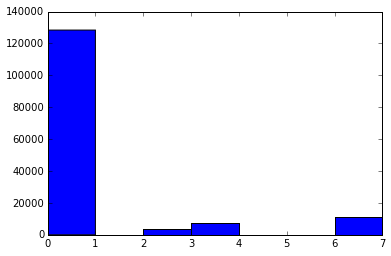

In [91]:
from sklearn import svm
from sklearn.qda import QDA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

#load and arrange data
truth, rawResults = reloadData()
data = transpose(rawResults) #arrange data into rows by profile for consumption by scikit-learn
shuffleLists(data, truth)    #randomize order of profiles
    
clf_SVM = svm.SVC(kernel='linear')
clf_QDA = QDA()
clf_KernelRidge = KernelRidge(kernel='linear')
clf_SGD = SGDClassifier(loss="hinge", penalty="l2")
clf_NearestCentroid = NearestCentroid()
clf_DecisionTree = tree.DecisionTreeClassifier()

clfs = [clf_SVM, clf_QDA, clf_KernelRidge, clf_SGD, clf_NearestCentroid, clf_DecisionTree]
histEntries = []

# train the classifiers
for clf in clfs:
    clf.fit(data[0:trainingSize], truth[0:trainingSize])
    
# poll classifiers and report
TT = 0.
TF = 0.
FT = 0.
FF = 0.

for i in range(trainingSize, len(truth)):
        flagsRaised = 0
        for clf in clfs:
            if clf.predict(data[i]):
                flagsRaised += 1
                
        histEntries.append(flagsRaised)
    
        assessment = flagsRaised >= len(clfs)/2
            
        if assessment and truth[i]:
            TT += 1
        elif assessment and not truth[i]:
            TF += 1
        elif not assessment and truth[i]:
            FT += 1
        elif not assessment and not truth[i]:
            FF += 1 
    
printSummary('Majority Poll', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

plt.hist(histEntries, bins=[0,1,2,3,4,5,6,7])
plt.show()

The plot shows the number of times n classifiers flagged a given dataset. Another simple approach is to flag a dataset if *any* of the classifiers flag it:

In [86]:
from sklearn import svm
from sklearn.qda import QDA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn import tree

#load and arrange data
truth, rawResults = reloadData()
data = transpose(rawResults) #arrange data into rows by profile for consumption by scikit-learn
shuffleLists(data, truth)    #randomize order of profiles
    
clf_SVM = svm.SVC(kernel='linear')
clf_QDA = QDA()
clf_KernelRidge = KernelRidge(kernel='linear')
clf_SGD = SGDClassifier(loss="hinge", penalty="l2")
clf_NearestCentroid = NearestCentroid()
clf_DecisionTree = tree.DecisionTreeClassifier()

clfs = [clf_SVM, clf_QDA, clf_KernelRidge, clf_SGD, clf_NearestCentroid, clf_DecisionTree]

# train the classifiers
for clf in clfs:
    clf.fit(data[0:trainingSize], truth[0:trainingSize])
    
# poll classifiers and report
TT = 0.
TF = 0.
FT = 0.
FF = 0.

for i in range(trainingSize, len(truth)):
        assessment = False
        for clf in clfs:
            assessment = assessment or clf.predict(data[i])
            
        if assessment and truth[i]:
            TT += 1
        elif assessment and not truth[i]:
            TF += 1
        elif not assessment and truth[i]:
            FT += 1
        elif not assessment and not truth[i]:
            FF += 1 
    
printSummary('Any Flag', TT/(datasetSize-trainingSize), TF/(datasetSize-trainingSize), FT/(datasetSize-trainingSize), FF/(datasetSize-trainingSize))

Any Flag
	 Correct flags: 0.0637919714564
	 False positive: 0.0845563609595
	 False negative: 0.0527698011102
	 Correct pass: 0.798881866474


So, flagging any profile that is flagged by an individual classifier performs better than the majority poll, but this performance is no better than Kernel Ridge or Quadratic Discriminant Analysis alone.